# Задача
- Произвести профилирование данных из набора данных, обеспечить их качество.
- Провести базовую аналитику.

# План работы  
1. Подготовка  
1.1. Подготовка к профилированию и анализу  
1.2. Анализ неочищенных данных  
1.3. Понимание данных  
2. Профилирование  
2.1. Приведение данных к одной форме  
2.1.1. email  
2.1.2. join_date  
2.1.3. age  
2.1.4. salary  
2.2. Чистка данных  
2.3. Поиск дубликатов по перемещению внутри компании  
3. Анализ  
3.1. Анализ уникальности и дубликатов  
3.2. Анализ полноты данных  
3.3. Анализ взаимосвязей и зависимостей  
5. Выводы  

# 1. Подготовка

## 1.1. Подготовка к профилированию и анализу

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
try:
    import gender_guesser.detector as gender
except ImportError:
    print("Библиотека gender-guesser (для угадывания пола) не установлена. Установка не обязательна.")

In [3]:
# Сохраним таблицу в DataFrame
df = pd.read_csv("data.csv")

## 1.2. Анализ неочищенных данных

In [4]:
# Определим количество строк и столбцов в таблице
df.shape

(1000, 6)

In [5]:
# Проверим данные фрэйма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   first_name  1000 non-null   object
 1   last_name   1000 non-null   object
 2   age         978 non-null    object
 3   email       999 non-null    object
 4   salary      988 non-null    object
 5   join_date   1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [6]:
df.describe()

,first_name,last_name,age,email,salary,join_date
count,1000,1000,978,999,988,1000
unique,52,42,50,54,947,687
top,Piper,Hall,24,invalid_email,not_available,2022-13-01
freq,32,34,32,50,19,50


In [7]:
# Распечатаем первые 5 строк таблицы
df.head()

,first_name,last_name,age,email,salary,join_date
0,Quincy,White,33,beatrice@example.com,64642,2022-08-07 00:00:00
1,Xena,Rodriguez,28,quincy@example.com,96273,2021-09-03 00:00:00
2,Leo,Smith,56,charlie@example.com,117527,2023-07-07 00:00:00
3,Jack,Allen,33,vera@example.com,54033,2021-12-02 00:00:00
4,Charlie,Taylor,38,quinn@example.com,30837,2023-12-05 00:00:00


In [8]:
# Количество пропущенных значений в каждом столбце
missing_values = df.isnull().sum()
print(f"Количество пропущенных значений в каждом столбце:\n{missing_values}\n")

# Процент пропущенных значений в каждом столбце
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(f"Процент пропущенных значений в каждом столбце:\n{missing_percentage}")

Количество пропущенных значений в каждом столбце:
first_name     0
last_name      0
age           22
email          1
salary        12
join_date      0
dtype: int64

Процент пропущенных значений в каждом столбце:
first_name    0.0
last_name     0.0
age           2.2
email         0.1
salary        1.2
join_date     0.0
dtype: float64


## 1.3. Понимание данных

Таблица содержит 6 столбцов, названия которых не ясно отражают содержание. Неизвестно когда таблица была создана (насколько данные актуальны). Из-за отсутствия уникального `id` сложно определить, дублируются ли данные в столбцах.   

Для анализа интересны столбцы (связи между ними): `age`, `salary` и `join_date`.

`age` - возраст на момент создание csv-файла, либо возраст при устройстве в компанию.  

`join_date` может означать как дату трудоустройства в компанию, так и перемещение по отделам или случай увольнения и повтороного трудоустройства.

`email` - только 54 уникальных адреса из 1000. Следовательно, нельзя рассматривать как уникальный ключ. Неясно, чьи адреса указаны.

Колонки `first_name` и `last_name` могут повторяться.

# 2. Профилирование

## 2.1. Приведение данных к одной форме

In [9]:
# Замена неизвестных данных на pd.NA
df.replace({
    "invalid_email": pd.NA,
    "not_available": pd.NA,
    "N/A": pd.NA,
    "na": pd.NA,
    "NA": pd.NA,
    "null": pd.NA,
    "nan": pd.NA,
    "": pd.NA,
    "unknown": pd.NA,
}, inplace=True)

In [10]:
# Сделаем каждое имя с заглавной буквы (в колонках first_name и last_name)
df["first_name"] = df["first_name"].str.capitalize()
df["last_name"] = df["last_name"].str.capitalize()

In [11]:
# Все email - прописными
df["email"] = df["email"].str.lower()

In [12]:
# Переведем age и salary в формат int64 (int с сохранением NaN)
df["age"] = df["age"].astype("Int64")
df["salary"] = df["salary"].astype("Int64")

### 2.1.1. email

Написание регулярного выражения для проверки email на валидность сложная и решенная задача. Воспользуемся готовым регулярным выражением.  
Источник: https://stackoverflow.com/questions/201323/how-can-i-validate-an-email-address-using-a-regular-expression.

Если email не валиден, заменим его на `NA`.

In [13]:
pattern = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

not_valid_emails = []

for email in df["email"]:
    try:
        re.match(pattern, email)
    except TypeError:
        not_valid_emails.append(email)
    else:
        if not re.match(pattern, email):
            not_valid_emails.append(email)

n_not_valid = len(not_valid_emails)
not_valid_emails_set = set(not_valid_emails)

print(f"Количество не прошедших проверку адресов: {n_not_valid / df.shape[0] * 100}% ({n_not_valid}).")

for email in df["email"]:
    if email in not_valid_emails_set:
        email = pd.NA

Количество не прошедших проверку адресов: 5.3% (53).


### 2.1.2. join_date

В таблице в графе `join_date` видим время двух форматов:
- Длина 19 символов: 2022-10-31 00:00:00
- Длина 10 символов: 2022-13-01

$dd \subset \{1, ..., 31\}$  
$mm \subset \{1, ..., 12\}$  

Предположим, что строка в 19 символов имеет формат yyyy-mm-dd, а строка в 10 символов - yyyy-dd-mm.
Проверим, что среди mm не встречается значений меньше $1$ и больше $12$, а среди dd - меньше $1$ или больше $31$.

Дата длины в 10 симоволов повторяется одна и та же: 2022-13-01 (либо "сбой формата экспорта данных в этот день", либо аномалия).

In [14]:
def clean_date(date):
    if pd.isna(date):
        return pd.NaT

    date = str(date).strip()

    match = re.match(r"(\d{4})-(\d{2})-(\d{2})", date)
    if not match:
        return pd.NaT

    y, a, b = match.groups()

    # Если длина строки 19, считаем формат yyyy-mm-dd
    if len(date) == 19:
        y, m, d = y, a, b
    # Если 10, то формат yyyy-dd-mm
    elif len(date) == 10:
        y, d, m = y, a, b
    else:
        return pd.NaT

    # Преобразуем в числа
    try:
        y, m, d = int(y), int(m), int(d)
    except:
        return pd.NaT

    # Проверим валидность дня и месяца
    if not (1 <= m <= 12 and 1 <= d <= 31):
        return pd.NaT

    # Обратно в строку, а затем в datetime
    fixed_date = f"{y:04d}-{m:02d}-{d:02d}"
    try:
        return pd.to_datetime(fixed_date)
    except:
        return pd.NaT

# Применяем к столбцу
df["join_date"] = df["join_date"].apply(clean_date)

# Считаем количество невалидных
invalid_count = df["join_date"].isna().sum()
print(f"Некорректных дат: {invalid_count}")

Некорректных дат: 0


### 2.1.3. age

-10
999


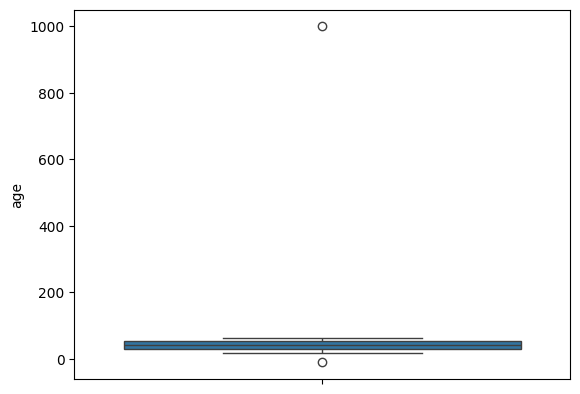

In [15]:
# Построим диаграмму boxplot

sns.boxplot(data=df["age"])

print(df["age"].min())
print(df["age"].max())

In [16]:
# Удаление аномалий
df.loc[(df["age"] < 0) | (df["age"] > 100), "age"] = pd.NA

18
64


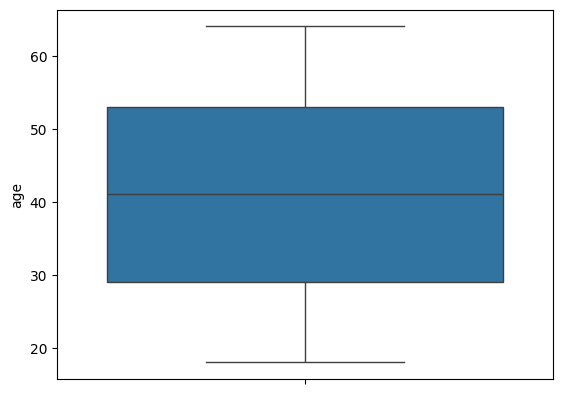

In [17]:
# Построим диаграмму boxplot

sns.boxplot(data=df["age"])

print(df["age"].min())
print(df["age"].max())

### 2.1.4. Salary

<Axes: ylabel='salary'>

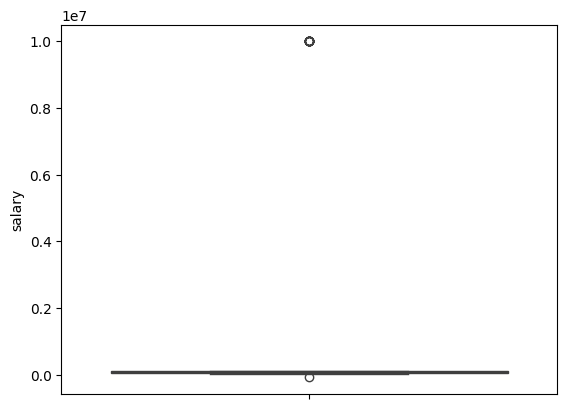

In [18]:
# Построим диаграмму boxplot

sns.boxplot(data=df["salary"])

In [19]:
# Удаление аномалий

df.loc[(df["salary"] < 0) | (df["salary"] > 1_000_000), "salary"] = pd.NA

30000
119998


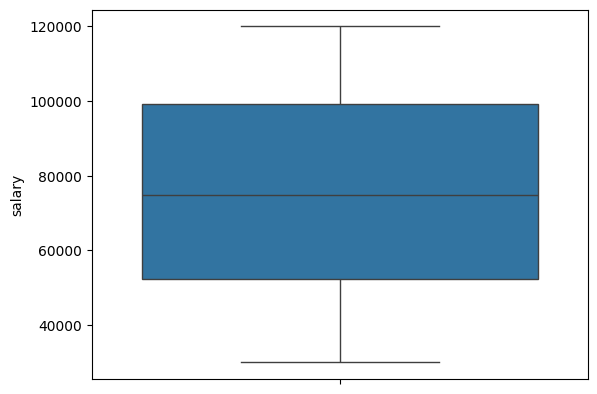

In [20]:
# Построим диаграмму boxplot

sns.boxplot(data=df["salary"])
print(df["salary"].min())
print(df["salary"].max())

## 2.2. Чистка данных

In [21]:
# Поиск слишком малых или больших дат
df.loc[(df["join_date"] > "2025-05-01") | (df["join_date"] < "1980-01-01")]

,first_name,last_name,age,email,salary,join_date
296,Henry,Johnson,38,uma@example.com,36070,2026-05-12
321,Olivia,Anderson,37,rachel@example.com,95423,1920-01-22


In [22]:
# Удаление аномалий
df.loc[(df["join_date"] > "2025-05-01") | (df["join_date"] < "1980-01-01")] = pd.NA

<Axes: ylabel='join_date'>

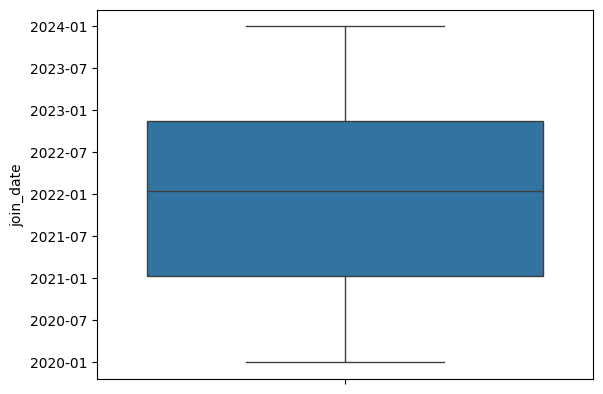

In [23]:
# Построим диаграмму boxplot
sns.boxplot(data=df["join_date"])

## 2.3. Поиск дубликатов по перемещению внутри компании
Попробуем найти записи, где имя и фамилия совпадают, а возраст увеличивается на разницу между `join_date` (то есть попытаемся найти сотрудников, которые, возможно, перемещались внутри компании (из отдела в отдел или получив повышение) и были продублированы.

In [24]:
# Вычисляем два возможных года рождения
df["birth_year_1"] = df["join_date"].dt.year - df["age"]
df["birth_year_2"] = df["join_date"].dt.year - df["age"] - 1

# Найдем дубли по имени и хотя бы одному из годов рождения
dupes = df[
    df.duplicated(subset=["first_name", "last_name", "birth_year_1"], keep=False) |
    df.duplicated(subset=["first_name", "last_name", "birth_year_2"], keep=False)
]

# Отображаем возможных людей с разными ролями
if not dupes.empty:
    print(dupes.sort_values(by=["first_name", "last_name", "birth_year_1"]))

df = df.drop(["birth_year_1", "birth_year_2"], axis=1)

    first_name last_name   age               email  salary  join_date  \
373       Jack  Williams    25   frank@example.com   36519 2022-02-11   
732       Jack  Williams    24     ivy@example.com   75563 2021-01-02   
233        Leo    Torres  <NA>  daniel@example.com   50234 2021-01-18   
698        Leo    Torres  <NA>   quinn@example.com  107256 2020-04-07   
333       Maya     Adams    38     zoe@example.com   84079 2021-12-13   
923       Maya     Adams    40   quinn@example.com   75462 2023-10-05   
52        Paul    Miller    55   kevin@example.com   87217 2021-11-27   
640       Paul    Miller    54  daniel@example.com  107018 2020-05-30   
296       <NA>      <NA>  <NA>                <NA>    <NA>        NaT   
321       <NA>      <NA>  <NA>                <NA>    <NA>        NaT   

     birth_year_1  birth_year_2  
373        1997.0        1996.0  
732        1997.0        1996.0  
233          <NA>          <NA>  
698          <NA>          <NA>  
333        1983.0        1

Такие связи не прослеживаются.

# 3. Анализ

## 3.1. Анализ уникальности и дубликатов

In [25]:
df.shape

(1000, 6)

In [26]:
# Удалить дубликаты, оставить последний
df = df.drop_duplicates(keep="last")

In [27]:
# Уникальные строки по комбинациям столбцов
print(df[["first_name", "last_name"]].drop_duplicates().shape[0])
print(df[["first_name", "last_name", "age"]].drop_duplicates().shape[0])
print(df[["first_name", "last_name", "join_date"]].drop_duplicates().shape[0])
print(df[["first_name", "last_name", "salary"]].drop_duplicates().shape[0])

787
998
999
999


Записей, в которых совпали имя и фамилия: 21%. Но из п. 2.3. видно, что только в 4 случаях эти повторения указывают на то, что это может быть один сотрудник (`join_date` и `age` меняется одинаково). Так как во всех случаях чем позже `join_date`, тем ниже зарплата (не типично), то, видимо, это разные люди.

In [28]:
df.describe()

,age,salary,join_date
count,945.0,951.0,998
mean,41.057143,75946.074658,2021-12-23 17:10:13.226452736
min,18.0,30000.0,2020-01-01 00:00:00
25%,29.0,52519.0,2021-01-11 18:00:00
50%,41.0,74834.0,2022-01-13 00:00:00
75%,53.0,99375.0,2022-11-14 06:00:00
max,64.0,119998.0,2023-12-31 00:00:00
std,13.703848,26689.476832,NaN


## 3.2. Анализ полноты данных

In [29]:
# 1. Количество пропущенных значений в каждом столбце
missing_values = df.isnull().sum()
print(f"Количество пропущенных значений в каждом столбце:\n{missing_values}")

# 2. Процент пропущенных значений в каждом столбце
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(f"\nПроцент пропущенных значений в каждом столбце:\n{missing_percentage}")

Количество пропущенных значений в каждом столбце:
first_name     1
last_name      1
age           54
email         52
salary        48
join_date      1
dtype: int64

Процент пропущенных значений в каждом столбце:
first_name    0.100100
last_name     0.100100
age           5.405405
email         5.205205
salary        4.804805
join_date     0.100100
dtype: float64


## 3.3. Анализ взаимосвязей и зависимостей

Проанализируем связь между возрастом и зарплатой и предполагаемым полом и зарплатой.

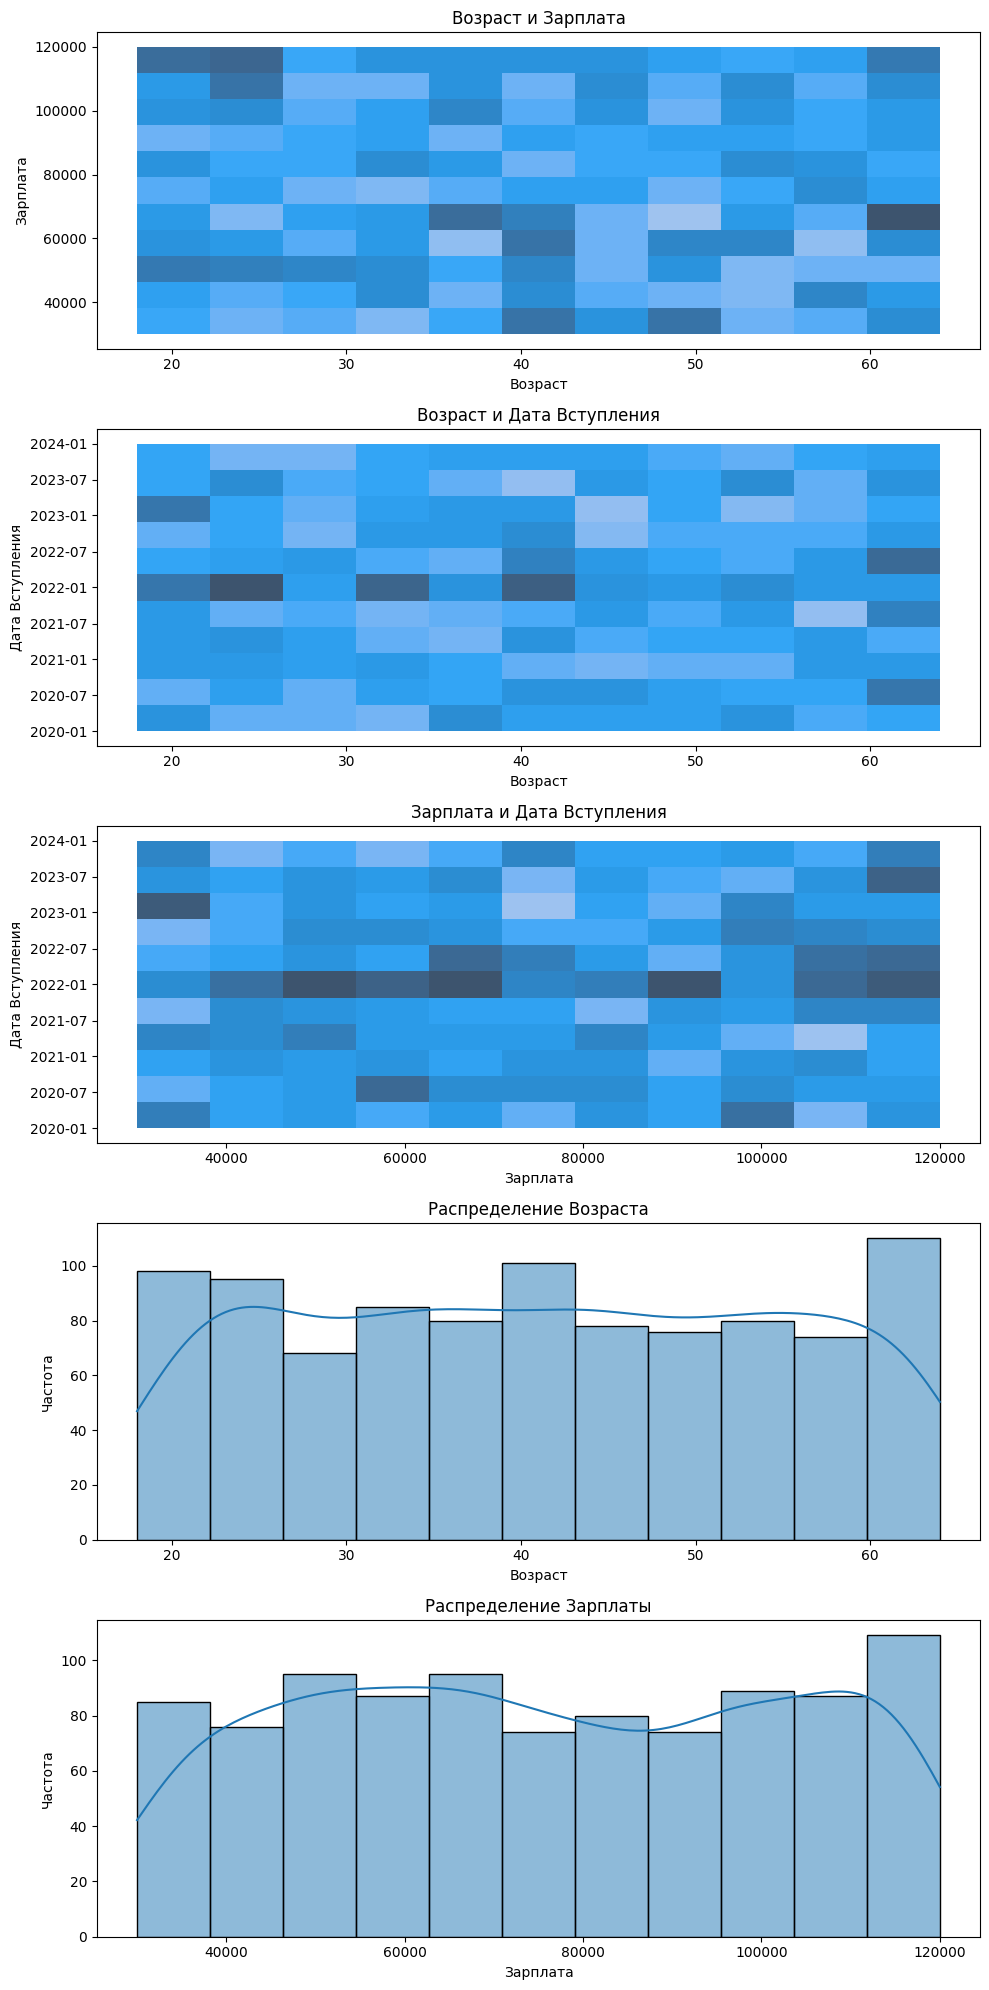

In [30]:
# Создадим фигуру с подграфиками для каждой пары переменных
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Возраст и зарплата
sns.histplot(df, x="age", y="salary", ax=axs[0], kde=True)
axs[0].set_title("Возраст и Зарплата")
axs[0].set_xlabel("Возраст")
axs[0].set_ylabel("Зарплата")

# Возраст и дата вступления
sns.histplot(df, x="age", y="join_date", ax=axs[1], kde=True)
axs[1].set_title("Возраст и Дата Вступления")
axs[1].set_xlabel("Возраст")
axs[1].set_ylabel("Дата Вступления")

# Зарплата и дата вступления
sns.histplot(df, x="salary", y="join_date", ax=axs[2], kde=True)
axs[2].set_title("Зарплата и Дата Вступления")
axs[2].set_xlabel("Зарплата")
axs[2].set_ylabel("Дата Вступления")

# Распределение возраста
sns.histplot(df["age"], kde=True, ax=axs[3])
axs[3].set_title("Распределение Возраста")
axs[3].set_xlabel("Возраст")
axs[3].set_ylabel("Частота")

# Распределение зарплаты
sns.histplot(df["salary"], kde=True, ax=axs[4])
axs[4].set_title("Распределение Зарплаты")
axs[4].set_xlabel("Зарплата")
axs[4].set_ylabel("Частота")

plt.tight_layout()
plt.show()


In [31]:
# Попробуем обнаружить связь по половому признаку.
try:
    d = gender.Detector()
except NameError:
    print("Библиотека gender-guesser (для угадывания пола) не импортирована.")
except AttributeError:
    print("Некорректный вызов модуля")
else:
    df["gender"] = df["first_name"].apply(lambda name: d.get_gender(name))

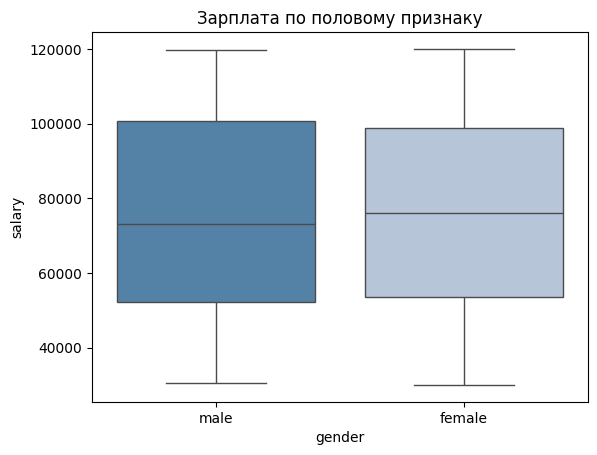

In [32]:
try:
    sns.boxplot(
        x="gender",
        y="salary",
        data=df[df["gender"].isin(["male", "female"])],
        hue="gender",
        legend=False,
        palette={"male": "#4682B4", "female": "#B0C4DE"},
    )
except ValueError as e:
    print(e)
else:
    plt.title("Зарплата по половому признаку")
    plt.show()

Slope: -50.61467403014622
P-value: 0.43984359617917923


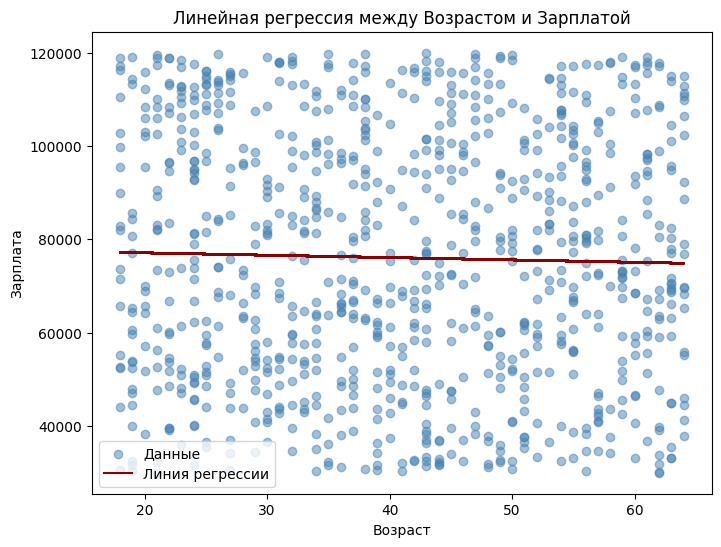

In [33]:
# Выполняем линейную регрессию
# Удаляем строки с NaN в age или salary
df_clean = df[["age", "salary"]].dropna()

# Строим линейную регрессию
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean["age"], df_clean["salary"])


# Печатаем результаты
print(f"Slope: {slope}")
print(f"P-value: {p_value}")

# График
plt.figure(figsize=(8, 6))
plt.scatter(df["age"], df["salary"], label="Данные", color="#4682B4", alpha=0.5)
plt.plot(df["age"], slope * df["age"] + intercept, color="darkred", label="Линия регрессии")
plt.title("Линейная регрессия между Возрастом и Зарплатой")
plt.xlabel("Возраст")
plt.ylabel("Зарплата")
plt.legend()
plt.show()

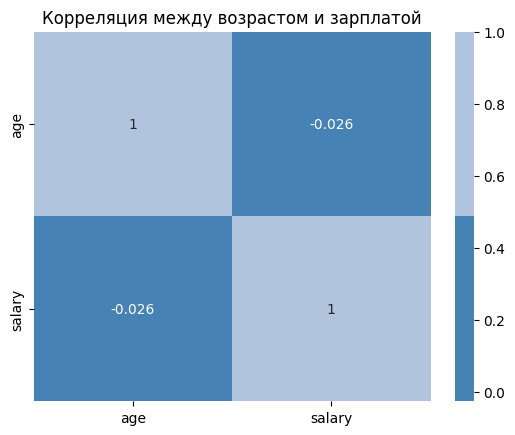

In [34]:
# Корреляция Пирсона

df_clean = df[["age", "salary"]].dropna()


correlation = df_clean.corr(method="pearson")

sns.heatmap(correlation, annot=True, cmap=["#4682B4", "#B0C4DE"])
plt.title("Корреляция между возрастом и зарплатой")
plt.show()

In [35]:
df.describe()

,age,salary,join_date
count,945.0,951.0,998
mean,41.057143,75946.074658,2021-12-23 17:10:13.226452736
min,18.0,30000.0,2020-01-01 00:00:00
25%,29.0,52519.0,2021-01-11 18:00:00
50%,41.0,74834.0,2022-01-13 00:00:00
75%,53.0,99375.0,2022-11-14 06:00:00
max,64.0,119998.0,2023-12-31 00:00:00
std,13.703848,26689.476832,NaN


# 4. Заключение


Проблемы в данных:
    
    Нет уникальных `ID`.
    
    `email` и `join_date` (формат) требуют проверки.

    Названия столбцов не всегда понятны.

    Много совпадений имён и фамилий (21%) при разном возрасте.

    Актуальность данных.

Основные статистики:

    Возраст: 18-64 (средний: 41).

    Зарплата: 30'000-119'998 (средняя: 75'946).

    Дата приёма (`join_date`): 2020-2023.

Анализ связей:

    Не обнаружено корреляции между возрастом и зарплатой.

    Не обнаружено связи между предполагаемым полом и зарплатой.